In [2]:
import argparse
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp     
import numpy as np
from jax.config import config

import awkward as awk

import flax
from flax import linen as nn          
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze
import optax   

import torch

from functools import partial

import uproot

import diffvert
import diffvert.models.NDIVE
from diffvert.utils.data_format import JetData, JetPrediction


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# (hopefully) reload local module so can use in development. must re-run on module change
import importlib
importlib.reload(diffvert)
importlib.reload(diffvert.models.NDIVE)
importlib.reload(diffvert.utils.data_format)
from diffvert.utils.data_format import JetData, JetPrediction

In [4]:
b_samples_dir = '/gpfs/slac/atlas/fs1/d/recsmith/Vertexing/samples/all_flavors/bjets'
c_samples_dir = '/gpfs/slac/atlas/fs1/d/recsmith/Vertexing/samples/all_flavors/cjets'
u_samples_dir = '/gpfs/slac/atlas/fs1/d/recsmith/Vertexing/samples/all_flavors/ujets'
b_test_dl = torch.load(f'{b_samples_dir}/test_dl.pth')
c_test_dl = torch.load(f'{c_samples_dir}/test_dl.pth')
u_test_dl = torch.load(f'{u_samples_dir}/test_dl.pth')
all_test_dl = [b_test_dl, c_test_dl, u_test_dl]

In [5]:
def dl_to_numpy(dl):
    """ Load in all batches from a dataloader as a single numpy arrary
    
    Args:
      dl: data object created from dataloader
    """
    data_list = [batch.x.numpy() for batch in dl]
    data_arr = np.concatenate(data_list, axis=0)
    return data_arr

In [6]:
b_test_arr = dl_to_numpy(b_test_dl)
c_test_arr = dl_to_numpy(c_test_dl)
u_test_arr = dl_to_numpy(u_test_dl)
all_test_arr = [b_test_arr, c_test_arr, u_test_arr]
b_test_arr.shape

(60000, 15, 51)

In [55]:
def graph_fn_processed(fn, ax, b_test_arr=None, c_test_arr=None, u_test_arr=None, hist_options: dict = dict()):
    """ graph a histogram of a function applied to b, c, u jets separately. acts on processed data
    
    assumes input data of 'num_jets' x 'track_ct' x 'track_params' format
    
    Args:
      fn: function to apply to each data set (can be jet-wise or track-wise)
      b/c/u_test_arr: numpy array of processed data
      hist_options: options to apply to histogram
    """
    hist_options.update(dict(histtype='step'))
    hist_options.update(dict(linewidth=2))
    if b_test_arr is not None:
      outs = fn(b_test_arr) 
      ax.hist(outs, weights=np.repeat(1/len(outs), len(outs)), label='b-jets', **hist_options)
    if c_test_arr is not None:
      outs = fn(c_test_arr) 
      ax.hist(outs, weights=np.repeat(1/len(outs), len(outs)), label='c-jets', **hist_options)
    if u_test_arr is not None:
      outs = fn(u_test_arr) 
      ax.hist(outs, weights=np.repeat(1/len(outs), len(outs)), label='light-jets', **hist_options)
    ax.set_ylabel("Arbitrary Units")
    ax.legend()

Text(0.5, 0, 'Number of tracks in jet')

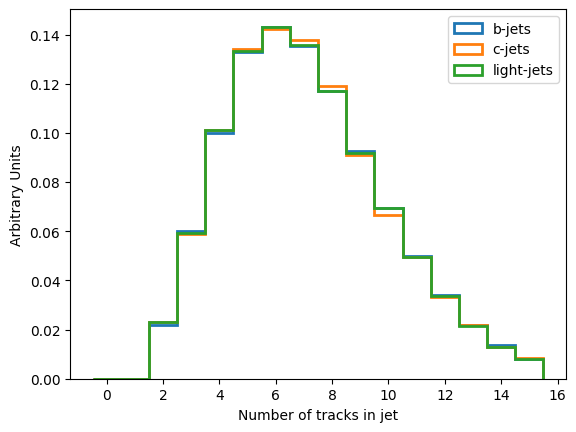

In [56]:
fig, ax = plt.subplots(1)
def n_trks(arr):
    """ return number of tracks in each jet"""
    return arr[:,0,JetData.N_TRACKS]
args = dict(range=(-0.5, 15.5), bins=16)
graph_fn_processed(n_trks, ax, *all_test_arr, args)
ax.set_xlabel("Number of tracks in jet")

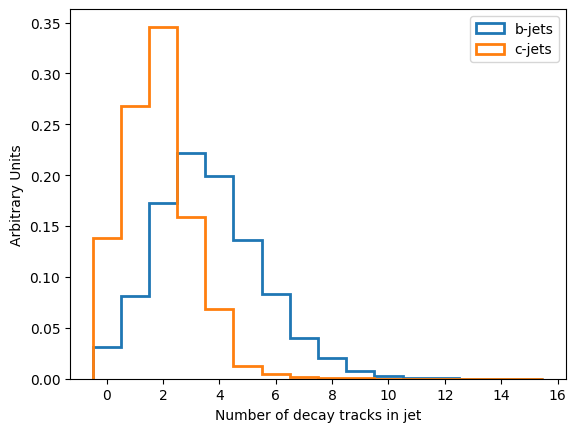

In [57]:
fig, ax = plt.subplots(1)
def n_trks_from_decay(arr):
    """ return number of tracks from b/c decay in each jet"""
    from_decay = np.logical_or(
        arr[:,:,JetData.TRACK_FROM_B].astype(int)==1,
        arr[:,:,JetData.TRACK_FROM_C].astype(int)==1
    )
    return np.sum(from_decay, axis=1)
args = dict(range=(-0.5, 15.5), bins=16)
graph_fn_processed(n_trks_from_decay, ax, b_test_arr, c_test_arr, hist_options=args)
ax.set_xlabel("Number of decay tracks in jet")
plt.savefig("plots/jettracks.pdf")

min pt: 23.012760162353516, max pt: 199.64895629882812


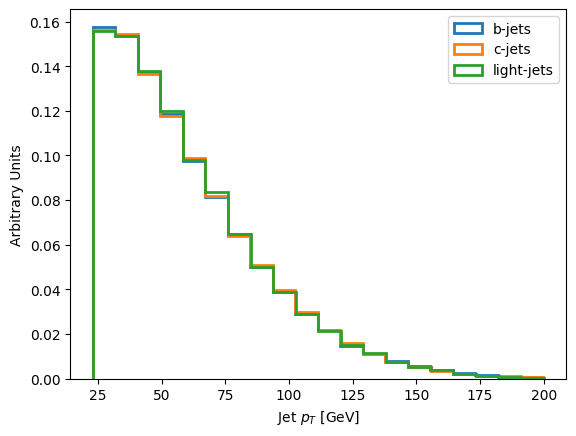

In [58]:
fig, ax = plt.subplots(1)
def jet_pt(arr):
    """ return pt by jet """
    return arr[:,0,JetData.TRACK_JET_PT]
args = dict(bins=20)
graph_fn_processed(jet_pt, ax, *all_test_arr, args)
ax.set_xlabel('Jet $p_{T}$ [GeV]')
print(f"min pt: {jnp.min(b_test_arr[:,0,JetData.TRACK_JET_PT])}, max pt: {jnp.max(b_test_arr[:,0,JetData.TRACK_JET_PT])}")
plt.savefig("plots/jetpt.pdf")

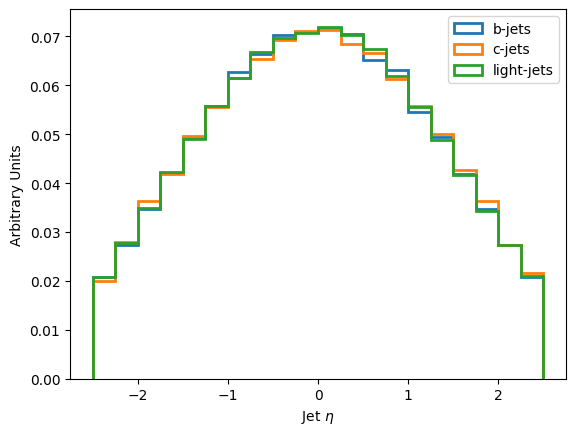

In [59]:
fig, ax = plt.subplots(1)
def jet_eta(arr):
    """ return pt by jet """
    return arr[:,0,JetData.TRACK_JET_ETA]
args = dict(bins=20)
graph_fn_processed(jet_eta, ax, *all_test_arr, args)
ax.set_xlabel('Jet $\eta$')
plt.savefig("plots/jeteta.pdf")

In [60]:
def per_track_fn(fn, arr: np.ndarray, complex_fn = False):
    """ create array resulting from applying function to all tracks in an array of processed track data 

    Args: 
      fn: function to be applied to tracks
      ax: axis to plot on
      arr: array of processed track data. will be padded to max_track number
      complex_fn: if True apply the function per axis, if false just do computation on array (maybe fix)
    Returns:
      1d array containing computed value per tracks
    """
    num_jets, max_num_tracks = arr.shape[0:2]

    # find out which indices of flattened array correspond to actual tracks
    n_trks = arr[:,0,JetData.N_TRACKS]
    n_trks_rep = np.repeat(n_trks, max_num_tracks).reshape((num_jets, max_num_tracks))
    indices = np.tile(np.arange(0, max_num_tracks), num_jets).reshape((num_jets, max_num_tracks))
    take = (indices < n_trks_rep).flatten()

    # apply function and then take appropriate indices
    if complex_fn:
        d0s = np.apply_along_axis(fn, 2, arr).flatten()
    else:
        d0s = fn(arr).flatten()
    d0s = d0s[take]
    return d0s

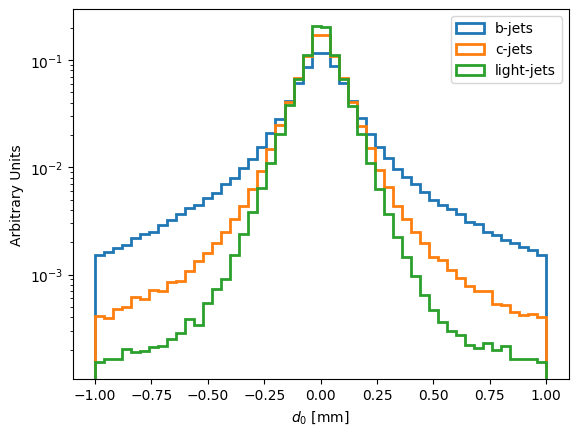

In [61]:
fig, ax = plt.subplots(1)
def d0(arr: np.ndarray):
    " get d0 for each track in a processed jet dataset "
    def get_d0(arr):
        return arr[:,:,JetData.TRACK_D0]
    return per_track_fn(get_d0, arr)

args = dict(range=(-1, 1), bins=50, log=True)
graph_fn_processed(d0, ax, *all_test_arr, args)
ax.set_xlabel("$d_0$ [mm]")
plt.savefig("plots/jetd0.pdf")

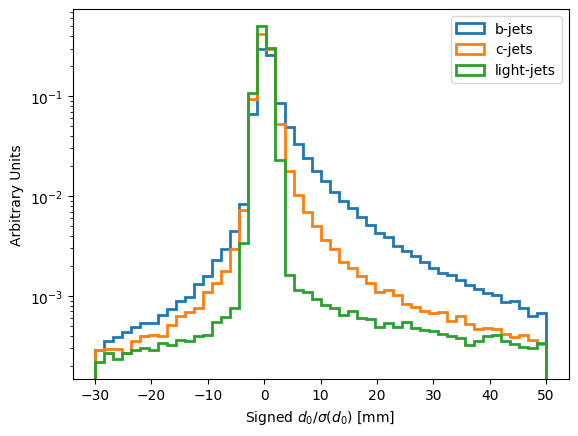

In [73]:
fig, ax = plt.subplots(1)
def signed_sigd0(arr: np.ndarray):
    " get signed d0 significance for each track in a processed jet dataset "
    def get_signed_sigd0(arr):
        return arr[:,:,JetData.TRACK_SIGNED_SIG_D0]
    return per_track_fn(get_signed_sigd0, arr)

args = dict(range=(-30, 50), bins=50, log=True)
graph_fn_processed(signed_sigd0, ax, *all_test_arr, args)
ax.set_xlabel("Signed $d_0/\sigma(d_0)$ [mm]")
plt.savefig("plots/jetsignedsigd0.pdf")

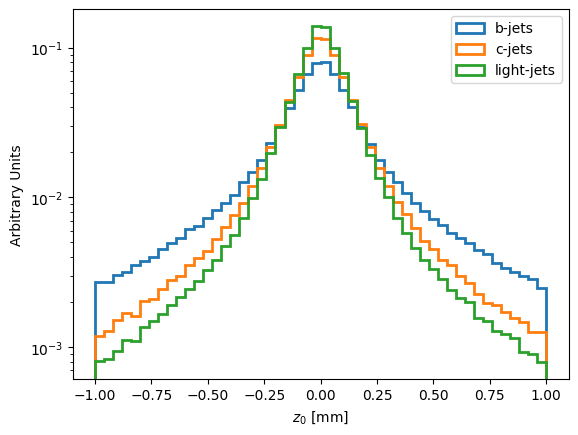

In [69]:
fig, ax = plt.subplots(1)
def z0(arr):
    """track-wise function returning all z0 values"""
    def get_z0(arr):
        return arr[:,:,JetData.TRACK_Z0]
    return per_track_fn(get_z0, arr)
args = dict(range=(-1, 1), bins=50, log=True)
graph_fn_processed(z0, ax, *all_test_arr, args)
ax.set_xlabel("$z_0$ [mm]")
plt.savefig("plots/jetz0.pdf")

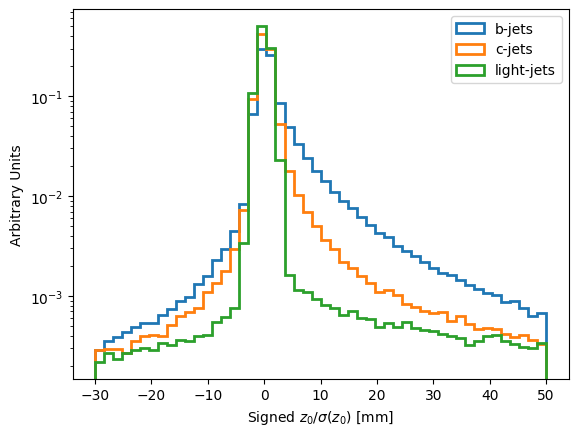

In [72]:
fig, ax = plt.subplots(1)
def signed_sigz0(arr):
    """track-wise function returning all signed z0 significance values"""
    def get_signed_sigz0(arr):
        return arr[:,:,JetData.TRACK_SIGNED_SIG_D0]
    return per_track_fn(get_signed_sigz0, arr)
args = dict(range=(-30, 50), bins=50, log=True)
graph_fn_processed(signed_sigz0, ax, *all_test_arr, args)
ax.set_xlabel("Signed $z_0/\sigma(z_0)$ [mm]")
plt.savefig("plots/jetsignedsigd0.pdf")

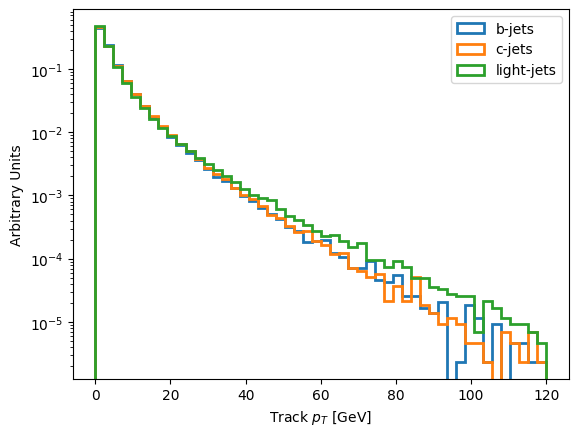

In [79]:
fig, ax = plt.subplots(1)
def pt(arr):
    """track-wise function returning all pt values"""
    def get_pt(arr):
        return arr[:,:,JetData.TRACK_PT]
    return per_track_fn(get_pt, arr)
args = dict(range=(0, 120), bins=50, log=True)
graph_fn_processed(pt, ax, *all_test_arr, args)
ax.set_xlabel("Track $p_{T}$ [GeV]")
plt.savefig("plots/trackpt.pdf")

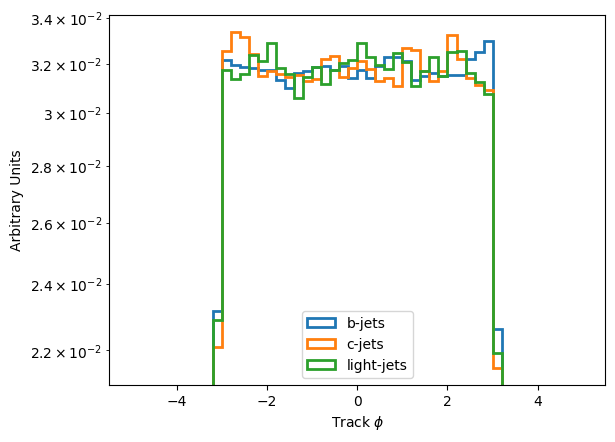

In [83]:
fig, ax = plt.subplots(1)
def phi(arr):
    """track-wise function returning all phi values"""
    def get_phi(arr):
        return arr[:,:,JetData.TRACK_PHI]
    return per_track_fn(get_phi, arr)
args = dict(range=(-5, 5), bins=50, log=True)
graph_fn_processed(phi, ax, *all_test_arr, args)
ax.set_xlabel("Track $\phi$")
plt.savefig("plots/trackphi.pdf")

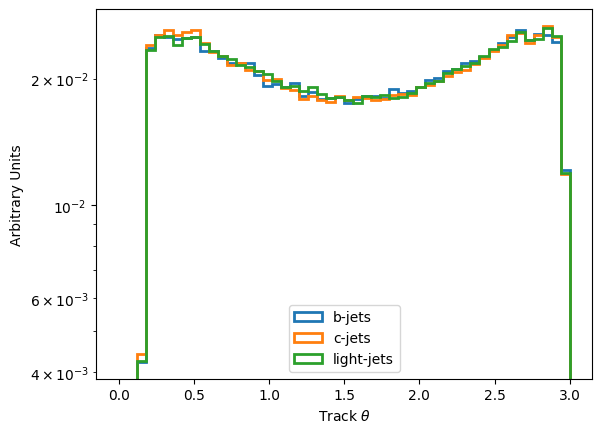

In [96]:
fig, ax = plt.subplots(1)
def theta(arr):
    """track-wise function returning all theta values"""
    def get_theta(arr):
        return arr[:,:,JetData.TRACK_THETA]
    return per_track_fn(get_theta, arr)
args = dict(range=(0, 3), bins=50, log=True)
graph_fn_processed(theta, ax, *all_test_arr, args)
ax.set_xlabel(r"Track $\theta$")
plt.savefig("plots/tracktheta.pdf")

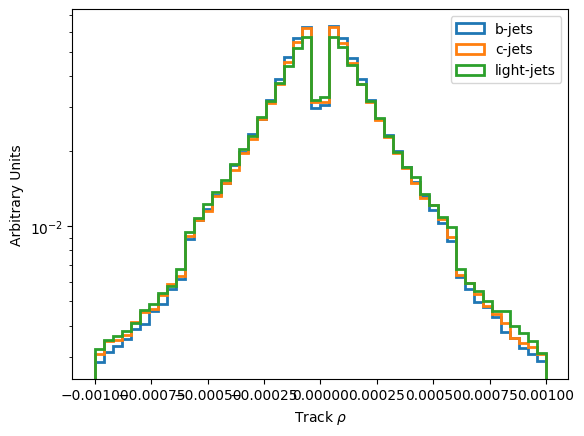

In [100]:
fig, ax = plt.subplots(1)
def rho(arr):
    """track-wise function returning all rho values"""
    def get_rho(arr):
        return arr[:,:,JetData.TRACK_RHO]
    return per_track_fn(get_rho, arr)
args = dict(range=(-1e-3, 1e-3), bins=50, log=True)
graph_fn_processed(rho, ax, *all_test_arr, args)
ax.set_xlabel(r"Track $\rho$")
plt.savefig("plots/trackrho.pdf")

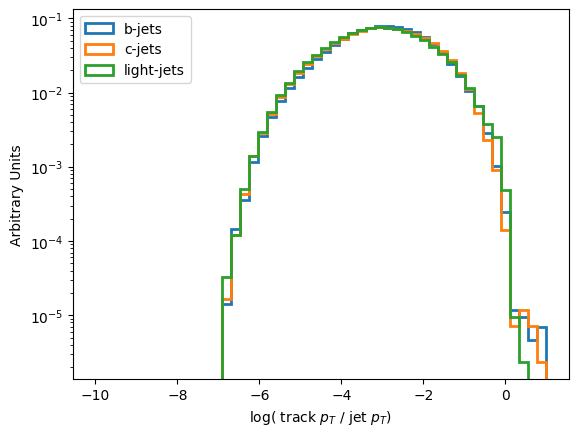

In [108]:
fig, ax = plt.subplots(1)
def logptfrac(arr):
    """track-wise function returning all TRACK_PT_FRACTION_LOG values"""
    def get_logptfrac(arr):
        return arr[:,:,JetData.TRACK_PT_FRACTION_LOG]
    return per_track_fn(get_logptfrac, arr)
args = dict(range=(-10,1), bins=50, log=True)
graph_fn_processed(logptfrac, ax, *all_test_arr, args)
ax.set_xlabel(r"log( track $p_{T}$ / jet $p_{T}$)")
plt.savefig("plots/tracklogptfrac.pdf")

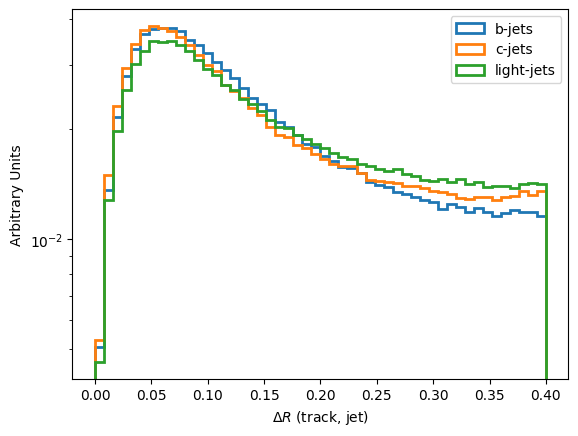

In [114]:
fig, ax = plt.subplots(1)
def dr(arr):
    """track-wise function returning all track delta R values"""
    def get_dr(arr):
        return arr[:,:,JetData.TRACK_DELTA_R]
    return per_track_fn(get_dr, arr)
args = dict(range=(0,0.4), bins=50, log=True)
graph_fn_processed(dr, ax, *all_test_arr, args)
ax.set_xlabel(r"$\Delta R$ (track, jet)")
plt.savefig("plots/trackdr.pdf")

Text(0.5, 0, 'fraction of jet pt from non-origin tracks')

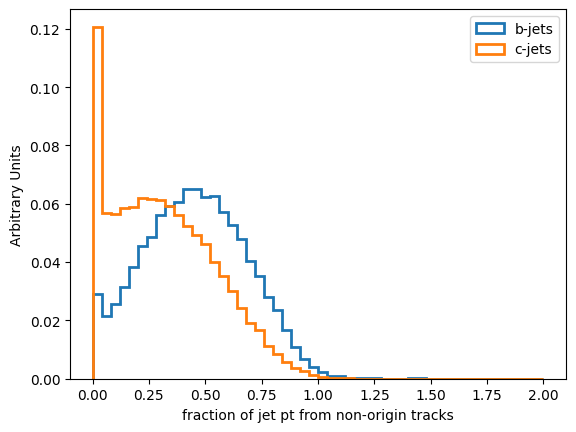

In [64]:
def pt_non_origin(arr, from_b_c_required=False):
    """ get sum of pt for all tracks which are not from the origin """

    num_jets, max_num_tracks = arr.shape[0:2]

    # find out which indices of flattened array correspond to actual tracks
    #   additionally require track to not be from origin
    n_trks = arr[:,0,JetData.N_TRACKS]
    trk_from_desired = arr[:,:,JetData.TRACK_FROM_ORIGIN] == 0
    if from_b_c_required:
        trk_from_desired = np.logical_or(arr[:,:,JetData.TRACK_FROM_B] == 1, arr[:,:,JetData.TRACK_FROM_C] == 1)
        
    n_trks_rep = np.repeat(n_trks, max_num_tracks).reshape((num_jets, max_num_tracks))
    indices = np.tile(np.arange(0, max_num_tracks), num_jets).reshape((num_jets, max_num_tracks))
    take = np.logical_and((indices < n_trks_rep), trk_from_desired)
    
    track_pt = arr[:,:,JetData.TRACK_PT]
    track_pt = np.where(take, track_pt, 0)
    jet_pt = arr[:,0,JetData.TRACK_JET_PT]

    track_phi = arr[:,:,JetData.TRACK_PHI]
    track_px = track_pt * np.cos(track_phi)
    track_py = track_pt * np.sin(track_phi)
    tot_track_px = np.sum(track_px, axis=1)
    tot_track_py = np.sum(track_py, axis=1)
    tot_track_pt = np.sqrt(np.square(tot_track_px)+np.square(tot_track_py))
    frac_pt_desired = tot_track_pt / jet_pt
    return frac_pt_desired
    
fig, ax = plt.subplots(1)
args = dict(range=(0,2), bins=50, log=False)
# graph_fn_processed(pt_non_origin, *all_test_arr, args)
# graph_fn_processed(partial(pt_non_origin, from_b_c_required=False), *all_test_arr, args)
graph_fn_processed(partial(pt_non_origin, from_b_c_required=False), ax, b_test_arr=b_test_arr, c_test_arr=c_test_arr, hist_options=args)

ax.set_xlabel("fraction of jet pt from non-origin tracks")

Text(0.5, 0, 'fraction of jet p from non-origin tracks (fragmentation var?)')

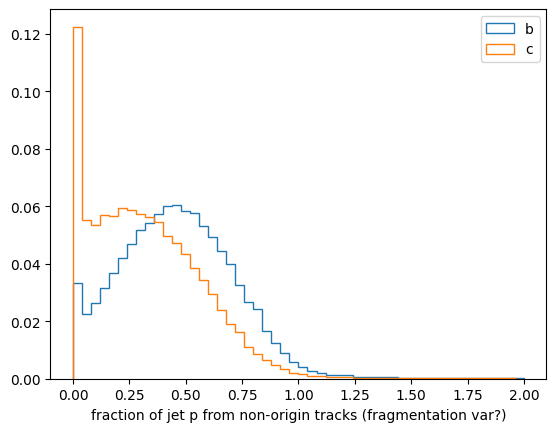

In [19]:
# WIP WIP WIP WIP
def fragmentation_along(arr, from_b_c_required=False):
    """ get sum of pt for all tracks which are not from the origin """

    num_jets, max_num_tracks = arr.shape[0:2]

    # find out which indices of flattened array correspond to actual tracks
    #   additionally require track to not be from origin
    n_trks = arr[:,0,JetData.N_TRACKS]
    trk_from_desired = arr[:,:,JetData.TRACK_FROM_ORIGIN] == 0
    if from_b_c_required:
        trk_from_desired = np.logical_or(arr[:,:,JetData.TRACK_FROM_B] == 1, arr[:,:,JetData.TRACK_FROM_C] == 1)
        
    n_trks_rep = np.repeat(n_trks, max_num_tracks).reshape((num_jets, max_num_tracks))
    indices = np.tile(np.arange(0, max_num_tracks), num_jets).reshape((num_jets, max_num_tracks))
    take = np.logical_and((indices < n_trks_rep), trk_from_desired)
    
    track_pt = arr[:,:,JetData.TRACK_PT]
    track_pt = np.where(take, track_pt, 0)
    jet_pt = arr[:,0,JetData.TRACK_JET_PT]
    jet_px = jet_pt*np.cos(arr[:,0,JetData.TRACK_JET_PHI])
    jet_py = jet_pt*np.sin(arr[:,0,JetData.TRACK_JET_PHI])
    jet_pz = jet_pt*np.tan(arr[:,0,JetData.TRACK_JET_THETA])
    jet_p2 = np.square(jet_pt / np.cos(arr[:,0,JetData.TRACK_JET_THETA]))

    track_phi = arr[:,:,JetData.TRACK_PHI]
    track_px = track_pt * np.cos(track_phi)
    track_py = track_pt * np.sin(track_phi)
    track_pz = track_pt * np.tan(arr[:,:,JetData.TRACK_THETA])
    
    tot_track_px = np.sum(track_px, axis=1)
    tot_track_py = np.sum(track_py, axis=1)
    tot_track_pz = np.sum(track_pz, axis=1)
    
    dot_prod = jet_px * tot_track_px + jet_py * tot_track_py + jet_pz * tot_track_pz
    
    frac_pt_desired = dot_prod / jet_p2
    return frac_pt_desired

fig, ax = plt.subplots(1)
args = dict(range=(0,2), bins=50, log=False)
graph_fn_processed(partial(fragmentation_along, from_b_c_required=False), ax, b_test_arr=b_test_arr, c_test_arr=c_test_arr, hist_options=args)

ax.set_xlabel("fraction of jet p from non-origin tracks (fragmentation var?)")

### Analyze Raw Data

Work with data loaded using uproot from the source, as opposed to data that has been preprocessed. Should look the same as preprocessed data

In [20]:
# load in raw data
TEST_DATA_FILE = '/gpfs/slac/atlas/fs1/d/recsmith/Vertexing/samples/test_data.root'
data = uproot.open(TEST_DATA_FILE)['tree']
data.keys()

['eventnb',
 'jet_pt',
 'jet_eta',
 'jet_phi',
 'jet_M',
 'jet_flav',
 'n_trks',
 'n_vertices',
 'trk_pythia_i',
 'trk_pdg_id',
 'trk_vtx_index',
 'trk_d0',
 'trk_z0',
 'trk_phi',
 'trk_ctgtheta',
 'trk_pt',
 'trk_charge',
 'trk_eta',
 'trk_d0err',
 'trk_z0err',
 'trk_phierr',
 'trk_ctgthetaerr',
 'trk_pterr',
 'trk_prod_x',
 'trk_prod_y',
 'trk_prod_z',
 'trk_dec_x',
 'trk_dec_y',
 'trk_dec_z',
 'hadron_pdgid',
 'hadron_decx',
 'hadron_decy',
 'hadron_decz',
 'hadron_x',
 'hadron_y',
 'hadron_z',
 'true_vtx_x',
 'true_vtx_y',
 'true_vtx_z',
 'true_vtx_L3D',
 'true_vtx_ntrks',
 'nChadrons',
 'nBhadrons',
 'nCdecay',
 'nBdecay',
 'BCdistance',
 'node_idx',
 'node_pdg_id',
 'edge_start',
 'edge_end',
 'edge_dist']

In [21]:
def graph_fn_raw(fn, data, hist_options: dict):
    """ Graph a function on raw uproot data

    assumes data not split by flavor
    Args:
      fn: function to apply to each input jet
      data: uproot loaded data
      hist_options: dict of plt hist options
    """
    proc_data = fn(data)
    jet_flav = data['jet_flav'].array(library='np').astype(int)
    plt.hist(proc_data[jet_flav==5], label='b', **hist_options)
    plt.hist(proc_data[jet_flav==4], label='c', **hist_options)
    plt.hist(proc_data[jet_flav==0], label='u', **hist_options)
    plt.legend()

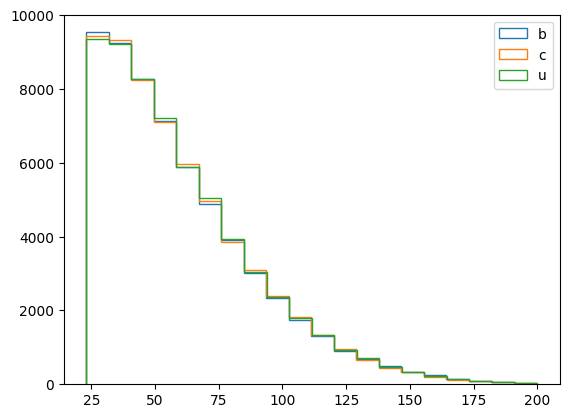

In [22]:
def get_pt(data):
    return data['jet_pt'].array(library='np')
args = dict(histtype='step', bins=20)
graph_fn_raw(get_pt, data, args)

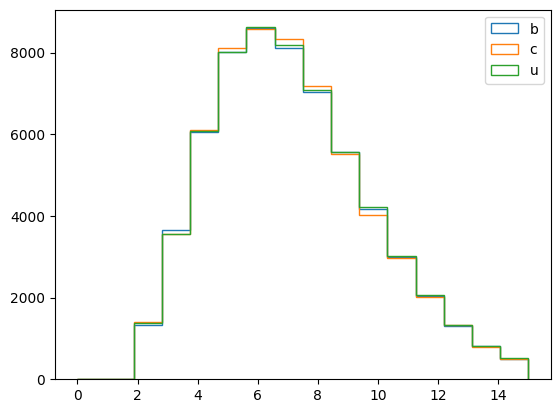

In [23]:
def get_ntrk_raw(data):
    return data['n_trks'].array(library='np')
args = dict(histtype='step', bins=16, range=(0,15))
graph_fn_raw(get_ntrk_raw, data, args)

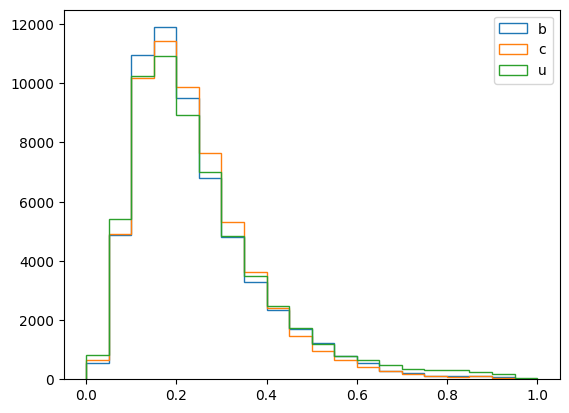

In [24]:
def highest_track_pt_ratio(data):
    """ get ratio of highest track pt to jet pt """
    arr = (awk.max(data['trk_pt'].array(), axis=1)/data['jet_pt'].array(library='np')).to_numpy()
    return arr
# lead_trk_indices = awk.argmax(data['trk_pt'].array(), axis=1).to_numpy()
args = dict(histtype='step', bins=20, range=(0,1))
graph_fn_raw(highest_track_pt_ratio, data, args)